In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

In [ ]:
# 使用 transforms.Compose 定义预处理操作，包括 ToTensor、Normalize 等；
# 使用 torchvision.datasets 下载 MNIST 数据集，同时作用之前定义的变换；
# 使用 DataLoader 对数据进行加载，批处理大小为 64，同时打乱数据加载
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])
train_set = torchvision.datasets.MNIST(root = "data",
                            transform=transform,
                            train = True,
                            download = True)
test_set = torchvision.datasets.MNIST(root="data",
                           transform = transform,
                           train = False,
                           download = False)
#装载数据
train_loader = torch.utils.data.dataloader.DataLoader(dataset=train_set,
                                                      batch_size = 64, shuffle = True)
test_loader = torch.utils.data.dataloader.DataLoader(dataset=test_set,
                                                     batch_size = 64, shuffle = True)

In [3]:
#生成器
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.linear1 = nn.Linear(100,256*7*7)
        self.bn1 = nn.BatchNorm1d(256*7*7)
        self.deconv1 = nn.ConvTranspose2d(256,128, kernel_size=(3,3), stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128,64, kernel_size=(4,4),stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(64,1,kernel_size=(4,4),stride=2, padding=1)
    def forward(self,x):
        x = F.relu(self.linear1(x)); x = self.bn1(x); x = x.view(-1, 256,7,7)
        x = F.relu(self.deconv1(x)); x = self.bn2(x)
        x = F.relu(self.deconv2(x)); x = self.bn3(x)
        x = torch.tanh(self.deconv3(x))
        return x

In [4]:
# 判别器
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2)
        self.bn = nn .BatchNorm2d(128 )
        self.fc = nn.Linear(128*6*6,1)
    def forward(self,x):
        x = F.dropout2d(F.leaky_relu(self.conv1(x)))
        x = F.dropout2d(F.leaky_relu(self.conv2(x)))
        x = self.bn(x)
        x = x.view(-1,128*6*6)
        x = torch.sigmoid(self.fc(x))
        return x

In [5]:
#实例化生成器和判别器
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gen = Generator().to(device)
dis = Discriminator().to(device)

In [6]:
#将损失函数loss_function 设置为二值交叉熵损失
loss_function = nn.BCELoss()
#将生成器和判别器的优化器均设为 Adam，并分别命名为 d_optim 和g_optim，学习率 lr 均为 1e-4
d_optim = optim.Adam(dis.parameters(), lr=1e-4)
g_optim = optim.Adam(gen.parameters(), lr=1e-4)

In [7]:
def generate_and_show_images(model, test_input, device):
    """图像生成和显示"""
    if device=='cuda':
        predictions = np.squeeze(model(test_input).detach().cpu().numpy())
    else:
        predictions = np.squeeze(model(test_input).detach().numpy())
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i + 1)
        plt.imshow((predictions[i] + 1) / 2,cmap='gray')
        plt.axis("off")
    plt.show( )

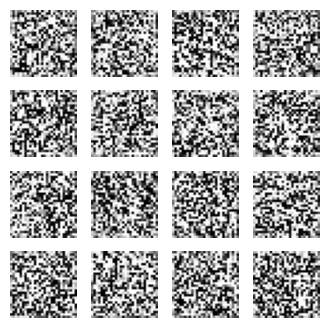

In [8]:
test_input = torch.randn(16,100,device=device)
generate_and_show_images(gen, test_input, device) #测试生成器

In [43]:
D_loss = [] # 判别器的损失值
G_loss = [] # 生成器的损失值
# 定义训练函数
def train(dataloader, epochs,desire_char = 10):
    for epoch in range(epochs):
        for i, (imgs, label) in enumerate(dataloader):
            imgs = imgs.to(device)
            # 训练判别器
            real_labels = torch.ones(imgs.size(0),1).to(device)
            fake_labels = torch.zeros(imgs.size(0),1).to(device)
            # 将真实图片和假图片分别输入判别器，并计算损失
            outputs = dis(imgs)
            d_loss_real = loss_function(outputs, real_labels)
            z = torch.randn(imgs.size(0),100).to(device)
            fake_imgs = gen(z)
            outputs = dis(fake_imgs)
            d_loss_fake = loss_function(outputs, fake_labels)
            d_loss = d_loss_real + d_loss_fake # 损失求和
            dis.zero_grad() # 清空梯度
            d_loss.backward() # 反向传播
            d_optim.step() # 更新参数
            
            # 训练生成器
            z = torch.randn(imgs.size(0),100).to(device)
            fake_imgs = gen(z)
            outputs = dis(fake_imgs)
            g_loss = loss_function(outputs, real_labels)
            gen.zero_grad() # 清空梯度
            g_loss.backward() # 反向传播
            g_optim.step() # 更新参数
            
            # 打印损失值
            if i % 300 == 0:
                print("Epoch:{}, iteration:{}, d_loss:{:.3f}, g_loss:{:.3f}".format(epoch, i, d_loss, g_loss))
                D_loss.append(d_loss.cpu().detach().numpy()) #取消梯度跟踪并将数据从GPU上转移到cpu上
                G_loss.append(g_loss.cpu().detach().numpy())

In [10]:
#训练模型
epochs=50
train(train_loader, epochs)

Epoch:0, iteration:0, d_loss:1.482, g_loss:0.707
Epoch:0, iteration:300, d_loss:0.602, g_loss:1.054
Epoch:0, iteration:600, d_loss:0.432, g_loss:2.030
Epoch:0, iteration:900, d_loss:0.470, g_loss:2.120
Epoch:1, iteration:0, d_loss:0.437, g_loss:2.196
Epoch:1, iteration:300, d_loss:0.433, g_loss:1.837
Epoch:1, iteration:600, d_loss:0.546, g_loss:2.048
Epoch:1, iteration:900, d_loss:0.272, g_loss:2.719
Epoch:2, iteration:0, d_loss:0.306, g_loss:2.588
Epoch:2, iteration:300, d_loss:0.322, g_loss:2.783
Epoch:2, iteration:600, d_loss:0.381, g_loss:2.787
Epoch:2, iteration:900, d_loss:0.512, g_loss:2.756
Epoch:3, iteration:0, d_loss:0.534, g_loss:2.357
Epoch:3, iteration:300, d_loss:0.354, g_loss:2.548
Epoch:3, iteration:600, d_loss:0.321, g_loss:1.883
Epoch:3, iteration:900, d_loss:0.336, g_loss:2.837
Epoch:4, iteration:0, d_loss:0.373, g_loss:2.932
Epoch:4, iteration:300, d_loss:0.737, g_loss:2.145
Epoch:4, iteration:600, d_loss:0.707, g_loss:2.413
Epoch:4, iteration:900, d_loss:0.775, g_l

In [11]:
print(torch.cuda.is_available())
print(device)

True
cuda


In [12]:
print(type(D_loss))

<class 'list'>


生成器和判别器从一开始都是非常弱的，因此一般不会在训练一开始两者损失就非常剧烈的波动。在训练一段时间达到稳定期后，生成器和判别器的损失都应该在一个小区间内波动，而不会有明显的持续上升/下降趋势。

如果生成器损失持续明显上升，表明其无法学习怎么欺骗判别器，体现在结果上就是开始生成噪声。

如果判别器损失持续明显上升，表示其无法学习怎么识别生成器，体现在结果上就是生成器可能会生成一致的，无意义的但是能欺骗判别器的图像(比如直接输出训练集中的样本)。

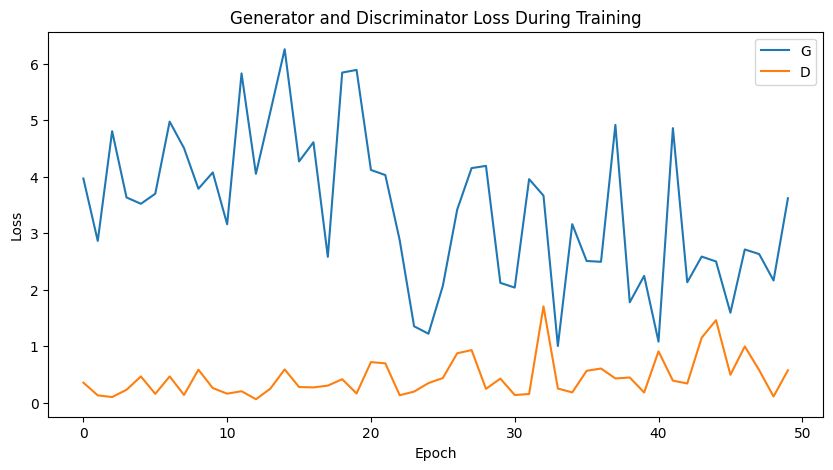

In [48]:
# 绘制损失函数曲线
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
#把 GPU tensor 转换成 Numpy 变量的时候，需要先将 tensor 转换到 CPU 去，因为 Numpy 是 CPU-only 的
plt.plot(G_loss,label="G")
plt.plot(D_loss,label="D")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

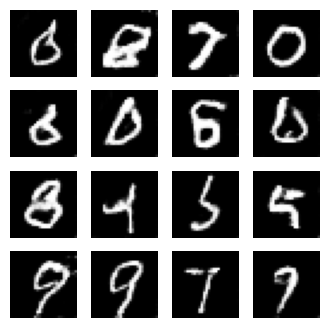

In [14]:
# 生成器生成的图片
test_input = torch.randn(16,100,device=device) #输入到生成器中的随机噪声
generate_and_show_images(gen, test_input, device)

In [41]:
desire_char = 3
input_tensor = torch.tensor([])
for i in range(len(train_set)):
    if train_set[i][1]==desire_char:
        #把标签为3的图片拼接起来
        input_tensor = torch.cat((input_tensor, train_set[i][0]),0)
    else :
        continue
input_tensor = input_tensor.unsqueeze(1) #增加一个维度
output_tensor = torch.tensor([desire_char]*input_tensor.shape[0])
train_ds = torch.utils.data.TensorDataset(input_tensor, output_tensor)
train_loader_desire = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)

In [44]:
#训练模型
epochs=50
train(train_loader_desire, epochs)

Epoch:0, iteration:0, d_loss:0.356, g_loss:3.970
Epoch:1, iteration:0, d_loss:0.131, g_loss:2.865
Epoch:2, iteration:0, d_loss:0.101, g_loss:4.808
Epoch:3, iteration:0, d_loss:0.230, g_loss:3.635
Epoch:4, iteration:0, d_loss:0.466, g_loss:3.522
Epoch:5, iteration:0, d_loss:0.157, g_loss:3.701
Epoch:6, iteration:0, d_loss:0.466, g_loss:4.977
Epoch:7, iteration:0, d_loss:0.138, g_loss:4.508
Epoch:8, iteration:0, d_loss:0.585, g_loss:3.789
Epoch:9, iteration:0, d_loss:0.260, g_loss:4.078
Epoch:10, iteration:0, d_loss:0.161, g_loss:3.160
Epoch:11, iteration:0, d_loss:0.204, g_loss:5.831
Epoch:12, iteration:0, d_loss:0.063, g_loss:4.053
Epoch:13, iteration:0, d_loss:0.249, g_loss:5.147
Epoch:14, iteration:0, d_loss:0.591, g_loss:6.259
Epoch:15, iteration:0, d_loss:0.279, g_loss:4.272
Epoch:16, iteration:0, d_loss:0.272, g_loss:4.612
Epoch:17, iteration:0, d_loss:0.303, g_loss:2.583
Epoch:18, iteration:0, d_loss:0.417, g_loss:5.845
Epoch:19, iteration:0, d_loss:0.164, g_loss:5.892
Epoch:20, 

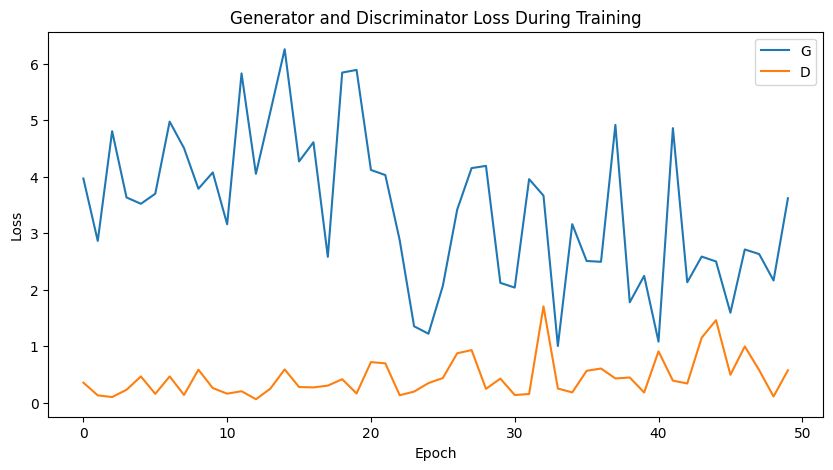

In [49]:
# 绘制损失函数曲线
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
#把 GPU tensor 转换成 Numpy 变量的时候，需要先将 tensor 转换到 CPU 去，因为 Numpy 是 CPU-only 的
plt.plot(G_loss,label="G")
plt.plot(D_loss,label="D")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

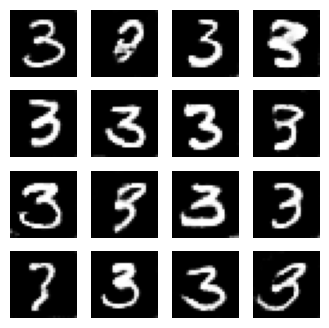

In [45]:
# 生成器生成的图片
test_input = torch.randn(16,100,device=device) #输入到生成器中的随机噪声
generate_and_show_images(gen, test_input, device)